# Импорт и параметры ("стандартные" значения)

In [ ]:
import numpy as np

import math
#from math import factorial

import scipy.integrate
import scipy.special
from scipy.special import kn #Macdonald function
from scipy.special import genlaguerre
from scipy.special import eval_genlaguerre
from scipy.special import expi
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

import torch
import torch.special
from torch.autograd import Function
from torch.special import gammaln
!pip install torchquad
import torchquad
from torchquad import GaussLegendre

from sympy.physics.quantum.spin import WignerD

import matplotlib.pyplot as plt

!pip install PyWavelets
import pywt

from tqdm import tqdm

In [ ]:
# Установим dtype и device для PyTorch (можно изменить при необходимости)
dtype = torch.float64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# "Стандартные" значения параметров
m = torch.tensor(1.0, dtype=dtype, device=device) # Масса частицы = масса электрона: 1
sigma = torch.tensor(2590.0, dtype=dtype, device=device) # Продольная ширина волнового пакета в компотоновских длинах волн: 2590 -> 1 nm
pzi = torch.tensor(0.196, dtype=dtype, device=device) # Продольный импульс начального электрона: 0.196 -> 100keV
si = 1 #
li = 1 # Орбитальное квантовое число начального электрона
pzf = torch.tensor(0.19599, dtype=dtype, device=device) # Продольный импульс конечного электрона: 0.19599 -> 99 994.9 eV
sf = 1
lf = 1 # Орбитальное квантовое число конечного электрона

kz = torch.tensor(1.96e-6, dtype=dtype, device=device) # Величина продольного импульса фотона: 1.96e-6 -> 1 eV
kp = torch.tensor(1.96e-7, dtype=dtype, device=device) # Величина поперечного импульса фотона: 1.96e-7 -> 0.1 eV
phi_k = torch.tensor(0.0, dtype=dtype, device=device) # Азимутальный угол импульса фотона: 0

lambda_ = torch.tensor(1.0, dtype=dtype, device=device) # Спиральность фотона: 1
F0 = torch.tensor(7.57e-8, dtype=dtype, device=device) # Сила со стороны электрического поля на заряд: 7.57e-8 -> 100 MeV/m
# t_C = 1.287e-21 s
# lambda_C = 3.86e-13 m
t_in = torch.tensor(2.56e7, dtype=dtype, device=device) # Время начала наблюдения: 2.56e7 t_c = 3.3e-8 s (соответствует расстоянию в 10 мкм при v = c)
t_out = torch.tensor(2.56e10, dtype=dtype, device=device) # Время пролёта ускорителя: 2.56e10 t_c = 3.3e-11 s (соответствует расстоянию в 1 см при v = c)
# H_c = 4.41e9 T
HtoHc = torch.tensor(2.27e-10, dtype=dtype, device=device) # Величина магнитного поля: 2.27e-10 -> 1T
rho_H = 2.0 / torch.sqrt(HtoHc) # Магнитная длина: для H = 1 T магнитная длина 132 744 комптоновских длин волн или 5.12e-8 m = 0.512 nm
# 1 / rho_H соответствует импульсу 7.53e-6 или 3.85 eV
q = torch.tensor(7.297e-3).sqrt().to(dtype=dtype, device=device) # Величина заряда частицы: 7.297e-3 -> q_e
sign = torch.tensor(-1.0, dtype=dtype, device=device) # Знак заряда частицы

kp_max = torch.tensor(1e-4, dtype=dtype, device=device) # Верхний предел интегрирования по величине поперечного импульса фотона: 1e-4 -> 51.1 eV
# kp_max должен быть заметно больше 1 / rho_H
pzf_min = -F0 * t_out # Нижний предел интегрирования по продольному импульсу конечного электрона
# Для F0 = 7.57e-8 = 100 MeV/m и t_out = 2.56e10 = 3.3e-11 s получаем pzf_min = 1.938e3 = 0.99 GeV

# Вспомогательные функции

In [ ]:
def factorial(n):
    if isinstance(n, torch.Tensor):
        return torch.exp(torch.special.gammaln(n + 1))
    else:
        n_tensor = torch.tensor(n, dtype=dtype, device=device)
        return torch.exp(torch.special.gammaln(n_tensor + 1))

# Полиномы Лагерра с положительными верхними индексами
def L_mod_1(n, alpha, x):
    # x — torch.tensor
    if n == 0:
        return torch.ones_like(x)
    elif n == 1:
        return 1 + alpha - x
    else:
        L0 = torch.ones_like(x)
        L1 = 1 + alpha - x
        for k in range(2, n + 1):
            Lk = ((2 * k - 1 + alpha - x) * L1 - (k - 1 + alpha) * L0) / k
            L0, L1 = L1, Lk
        return L1

# Полиномы Лагерра с отрицательными верхними индексами
def L_mod(n, alpha, x):
    if alpha > -1:
        return L_mod_1(n,alpha,x)
    else:
        return L_mod_1(n+alpha,-alpha,x)*(-x)**(-alpha)*factorial(n+alpha)/factorial(n)

# Квадрат поперечного импульса
def pp2(s, l, HtoHc, sign):
    l = torch.tensor(l, dtype=dtype, device=device)
    l_abs = torch.abs(l)
    return 2 * HtoHc * (s + l_abs / 2 - sign * l / 2 + 0.5)

# Классическая функция энергии
def En(s, l, pz, t, HtoHc, sign, F0, m):
    return torch.sqrt(m**2 + pp2(s, l, HtoHc, sign) + (pz + F0 * t)**2)

# Классическая продольная траектория
def z(s, l, pz, t, HtoHc, sign, F0, m):
    return (En(s, l, pz, t, HtoHc, sign, F0, m) - En(s, l, pz, 0.0, HtoHc, sign, F0, m)) / F0

# Интеграл от энергии от 0 до t, входящий в действие (здесь интегрируем именно от 0, а не от t_in)
def IntEn(s, l, pz, t, HtoHc, sign, F0, m):
    En_t  = En(s, l, pz, t, HtoHc, sign, F0, m)
    En_0  = En(s, l, pz, 0.0, HtoHc, sign, F0, m)
    En00  = En(s, l, 0.0, 0.0, HtoHc, sign, F0, m)

    term1 = (pz + F0 * t) * En_t - pz * En_0

    num   = pz + F0 * t + En_t
    denom = pz + En_0
    # avoid div by 0 or negative log
    eps = 1e-30
    frac = torch.clamp(torch.abs(num / denom), min=eps)

    term2 = En00**2 * torch.log(frac)

    return (term1 + term2) / (2 * F0)

# Интегральная экспонента
class Exp1Function(Function):
    @staticmethod
    def forward(ctx, input):
        input_np = input.detach().cpu().numpy()
        output_np = scipy.special.exp1(input_np)  # для комплексных значений
        output = torch.from_numpy(np.array(output_np)).to(input.device).type_as(input)
        ctx.save_for_backward(input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = -torch.exp(-input) / input
        return grad_output * grad_input

def exp1(x: torch.Tensor) -> torch.Tensor:
    return Exp1Function.apply(x)

# Интеграл по времени от t_in до бесконечности в приближении F0 * t >> pzi, pzf
def K(kp, pzi, pzf, t_in):
    kz = pzi - pzf
    dpz = pzi + pzf
    phase = -1j / (2 * F0) * (torch.sqrt(kp ** 2 + kz ** 2) - kz) * dpz
    arg = -1j * (torch.sqrt(kp ** 2 + kz ** 2) - kz + 1j * 1e-40) * (t_in + dpz / (2 * F0))
    return torch.exp(phase) * exp1(arg)

# интеграл по времени от t_in до t_out
def Kprime(kp, pzi, pzf, t_in, t_out):
    return K(kp, pzi, pzf, t_in) - K(kp, pzi, pzf, t_out)

# Интеграл по поперечной координате
def Ffun(si, li, sf, lf, y):
    sf_lf_fact = factorial(sf + lf)
    si_fact = factorial(si)

    exponent = 3*(si - sf) + 2*li - lf + 2
    y_power = y**(2*(si - sf) + li - lf)

    y_sq = y**2
    L1 = L_mod(sf + lf, (si - sf + li - lf), y_sq / torch.tensor(8, dtype=dtype, device=device))
    L2 = L_mod(sf, (si - sf), y_sq / torch.tensor(8, dtype=dtype, device=device))

    exp_term = torch.exp(-y_sq / torch.tensor(8, dtype=dtype, device=device))

    return (sf_lf_fact / si_fact) * (1 / 2**exponent) * y_power * L1 * L2 * exp_term

def Ip1(si, li, sf, lf, y):
    term1 = 2 * Ffun(si, li, sf, lf + 1, y)
    term2 = (si + li) * Ffun(si, li - 1, sf, lf, y)
    return (-1j) * torch.sqrt(torch.tensor(2.0, device=device)) * (term1 + term2)

def Im1(si, li, sf, lf, y):
    term1 = 2 * Ffun(si, li + 1, sf, lf, y)
    term2 = (sf + lf) * Ffun(si, li, sf, lf - 1, y)
    return (-1j) * torch.sqrt(torch.tensor(2.0, device=device)) * (term1 + term2)

# Регуляризация
eps = torch.tensor(1e-30)

# Члены суммы по проекциям спина фотона на ось z в S_fi
def TT_wide(si, li, pzi, sf, lf, pzf, kp, y, tin, tout):
    kz = pzi - pzf
    omega = torch.sqrt(kp**2 + kz**2)

    tint1 = Kprime(kp, pzi, pzf, tin, tout) / F0
    denominator = 1j * (omega - kz + 1j * eps)
    tint0 = (2 * torch.exp(1j * (omega - kz) * tin)) / denominator - \
            (2 * torch.exp(1j * (omega - kz) * tout)) / denominator

    term1 = Im1(si, li, sf, lf, y) * tint1
    term2 = rho_H * Ffun(si, li, sf, lf, y) * tint0
    term3 = Ip1(si, li, sf, lf, y) * tint1

    return torch.stack([term1, term2, term3])

def wigner_d_matrix_j1_torch(sigma_pol: int, lambda_val: int, beta: torch.Tensor) -> torch.Tensor:

    # Убедимся, что beta является тензором и на правильном устройстве
    if not isinstance(beta, torch.Tensor):
        raise TypeError("beta must be a torch.Tensor")

    # Определение dtype и device из beta
    dtype = beta.dtype
    device = beta.device

    cos_beta = torch.cos(beta)
    sin_beta = torch.sin(beta)
    sqrt_2 = torch.sqrt(torch.tensor(2.0, dtype=dtype, device=device))

    # d^1_{m'm}(beta)
    # Используем сложную структуру if/elif/else для охвата всех 9 элементов матрицы.
    # Это позволяет избежать создания большой таблицы поиска и делает логику явной.

    if sigma_pol == 1:
        if lambda_val == 1:
            return (1 + cos_beta) / 2
        elif lambda_val == -1:
            return (1 - cos_beta) / 2
    elif sigma_pol == 0:
        if lambda_val == 1:
            return sin_beta / sqrt_2
        elif lambda_val == -1:
            return -sin_beta / sqrt_2
    elif sigma_pol == -1:
        if lambda_val == 1:
            return (1 - cos_beta) / 2
        elif lambda_val == -1:
            return (1 + cos_beta) / 2

    # Если индексы sigma_pol или lambda_val выходят за пределы [-1, 0, 1]
    raise ValueError(f"Недопустимые индексы для j=1 d-матрицы: sigma_pol={sigma_pol}, lambda_val={lambda_val}. Они должны быть -1, 0 или 1.")


# Матричный элемент в приближении широкого пакета
def Sfi_wide(si, li, pzi, sf, lf, pzf, kp, phi_k, lambda_, t_in, t_out):
    # Ensure all inputs are tensors and on the correct device
    # Convert scalar inputs to tensors if they aren't already

    si_t = torch.tensor(si, dtype=dtype, device=device) if not isinstance(si, torch.Tensor) else si.clone().detach()
    li_t = torch.tensor(li, dtype=dtype, device=device) if not isinstance(li, torch.Tensor) else li.clone().detach()
    sf_t = torch.tensor(sf, dtype=dtype, device=device) if not isinstance(sf, torch.Tensor) else sf.clone().detach()
    lf_t = torch.tensor(lf, dtype=dtype, device=device) if not isinstance(lf, torch.Tensor) else lf.clone().detach()
    lambda_t = torch.tensor(lambda_, dtype=dtype, device=device) if not isinstance(lambda_, torch.Tensor) else lambda_.clone().detach()
    # Pre-calculate common terms for efficiency
    pzi_minus_pzf = pzi - pzf
    kp_sq_plus_pzm_sq = kp**2 + pzi_minus_pzf**2

    sqrt1 = torch.sqrt((2**(torch.abs(li_t) + 1)) / (torch.pi * rho_H**2) * factorial(si_t) / factorial(si_t + li_t))
    sqrt2 = torch.sqrt((2**(torch.abs(lf_t) + 1)) / (torch.pi * rho_H**2) * factorial(sf_t) / factorial(sf_t + lf_t))

    photon_norm = 1 / torch.sqrt(2 * torch.sqrt(kp_sq_plus_pzm_sq))
    # Общий префактор
    prefactor = -2 * torch.pi * 1j * photon_norm * sqrt1 * sqrt2 * (q * rho_H) / (2 * m)
    exp_term = torch.exp(1j * (li_t - lf_t) * phi_k)


    # Второй член в разложении разности координат
    z_exp_factor = torch.exp(-(pzi - En(si, li, pzi, 0, HtoHc, sign, F0, m) - pzf + En(sf, lf, pzf, 0, HtoHc, sign, F0, m))**2 / F0**2 / (4 * sigma**2))


    # Вычисление суммы

    total_sum = torch.zeros_like(kp, dtype=torch.complex128, device=device)
    # Calculate the angle for WignerD
    angle_for_wigner_d = torch.atan2(kp, pzi_minus_pzf)
    # Convert lambda_ to int for wigner_d_matrix_j1_torch
    lambda_int = int(lambda_t.item()) # Use .item() to get Python scalar from 0-dim tensor
    for sigma_pol in range(-1, 2):  # sigma_pol = -1, 0, 1
        i_power = (1j)**(sigma_pol - li_t + lf_t)
        # Get the Wigner D value using the new PyTorch function
        wigner_d_val = wigner_d_matrix_j1_torch(sigma_pol, lambda_int, angle_for_wigner_d)
        # Get the corresponding element from TT
        # Ensure si, li, sf, lf are passed as Python ints to TT_wide's internal functions
        tt_elements = TT_wide(int(si_t.item()), int(li_t.item()), pzi, int(sf_t.item()), int(lf_t.item()), pzf, kp, kp * rho_H, t_in, t_out)
        tt_element = tt_elements[sigma_pol + 1]
        # Add to the sum
        total_sum += i_power * wigner_d_val * tt_element
    result = prefactor * exp_term * total_sum * z_exp_factor
    return result

# Вероятность и интенсивность излучения

In [ ]:
# Функция для сглаживания быстро осциллирующих функций (выдаёт "среднее значение")
def apply_savgol_filter_to_tensor(data_tensor, sigma):
    data_np = data_tensor.clone().detach().cpu().numpy()
    smoothed_np = gaussian_filter1d(data_np, sigma=sigma)
    return torch.as_tensor(smoothed_np, dtype=data_tensor.dtype, device=data_tensor.device)

def smooth_wavelet(data, wavelet='sym4', level=3, sigma=1.0):
    log_data = np.log10(data)

    # Вейвлет-фильтрация
    coeffs = pywt.wavedec(log_data, wavelet, level=level)
    threshold = 0.2 * np.max(np.abs(coeffs[-1]))  # Мягкий порог
    coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    smoothed_log = pywt.waverec(coeffs, wavelet)

    # Дополнительное Гауссово сглаживание
    smoothed_log = gaussian_filter1d(smoothed_log, sigma=sigma)

    return 10**smoothed_log

In [ ]:
# ------------------ S_fi -------------------

# Сглаженный матричный элемент
# Только для визуализации - не использовать в сглаженных вероятностях
def Sfi_wide_sm(si, li, pzi, sf, lf, pzf, kp, phi_k, lambda_, t_in, t_out):
    return apply_savgol_filter_to_tensor(
        Sfi_wide(si, li, pzi, sf, lf, pzf, kp, phi_k, lambda_, t_in, t_out), 20)


# ------------------ Intensity -------------------

# Спектральная интенсивность: d^2 I / (d pzf d k_perp)
def spec_int_unpol_wide(si, li, pzi, sf, lf, pzf, kp, t_in, t_out):
    energy_factor = torch.sqrt(kp**2 + (pzi-pzf)**2)
    measure_factor = (2 * torch.pi)**-3
    S_elem2 = kp * (torch.abs(Sfi_wide(si, li, pzi, sf, lf, pzf, kp, 0, 1, t_in, t_out))**2 +
                   torch.abs(Sfi_wide(si, li, pzi, sf, lf, pzf, kp, 0, -1, t_in, t_out))**2)
    return 2 * torch.pi * measure_factor * S_elem2 * energy_factor


# ------------------ Differential Probability -------------------

# Сглаженная дифференциальная вероятность: d W / d pzf

def dW_dpzf_pol_wide_sm_old(si, li, pzi, sf, lf, pzf, lambda_, t_in, t_out, kp_max):
    measure_factor = (2 * torch.pi)**-3
    gl = torchquad.GaussLegendre()

    def integrand(x):
        # Используем clone().detach() для входных данных
        x_tensor = x.clone().detach() if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=dtype, device=device)
        return x_tensor * torch.abs(Sfi_wide_sm(si, li, pzi, sf, lf, pzf, x_tensor, 0, lambda_, t_in, t_out))**2

    int_result = gl.integrate(integrand, dim=1, N=101, integration_domain=[[1e-10, float(kp_max)]])
    return 2 * torch.pi * measure_factor * int_result


def dW_dpzf_pol_wide_sm(si, li, pzi, sf, lf, pzf, lambda_, t_in, t_out, kp_max):
    measure_factor = (2 * torch.pi)**-3
    gl = torchquad.GaussLegendre()

    def integrand(x):
        # Используем clone().detach() для входных данных
        x_tensor = x.clone().detach() if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=dtype, device=device)
        return apply_savgol_filter_to_tensor(x_tensor * torch.abs(Sfi_wide(si, li, pzi, sf, lf, pzf, x_tensor, 0, lambda_, t_in, t_out))**2, 20)

    int_result = gl.integrate(integrand, dim=1, N=101, integration_domain=[[1e-10, float(kp_max)]])
    return 2 * torch.pi * measure_factor * int_result

# Просуммированная по поляризациям фотона сглаженная дифференциальная вероятность: d W / d pzf
def dW_dpzf_unpol_wide_sm_old(si, li, pzi, sf, lf, pzf, t_in, t_out, kp_max):
    return dW_dpzf_pol_wide_sm_old(si, li, pzi, sf, lf, pzf, 1, t_in, t_out, kp_max) + dW_dpzf_pol_wide_sm_old(si, li, pzi, sf, lf, pzf, -1, t_in, t_out, kp_max)

def dW_dpzf_unpol_wide_sm(si, li, pzi, sf, lf, pzf, t_in, t_out, kp_max):
    return dW_dpzf_pol_wide_sm(si, li, pzi, sf, lf, pzf, 1, t_in, t_out, kp_max) + dW_dpzf_pol_wide_sm(si, li, pzi, sf, lf, pzf, -1, t_in, t_out, kp_max)

# Несглаженная дифференциальная вероятность: d W / d pzf
def dW_dpzf_pol_wide(si, li, pzi, sf, lf, pzf, lambda_, t_in, t_out, kp_max):
    measure_factor = (2 * torch.pi)**-3
    gl = torchquad.GaussLegendre()

    def integrand(x):
        x_tensor = x.clone().detach() if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=dtype, device=device)
        return x_tensor * torch.abs(Sfi_wide(si, li, pzi, sf, lf, pzf, x_tensor, 0, lambda_, t_in, t_out))**2

    int_result = gl.integrate(integrand, dim=1, N=101, integration_domain=[[1e-10, float(kp_max)]])
    return 2 * torch.pi * measure_factor * int_result

# Просуммированная по поляризациям фотона несглаженная дифференциальная вероятность: d W / d pzf
def dW_dpzf_unpol_wide(si, li, pzi, sf, lf, pzf, t_in, t_out, kp_max):
    return dW_dpzf_pol_wide(si, li, pzi, sf, lf, pzf, 1, t_in, t_out, kp_max) + dW_dpzf_pol_wide(si, li, pzi, sf, lf, pzf, -1, t_in, t_out, kp_max)


# ------------------ Full Probability -------------------

def full_prob(si, li, pzi, sf, lf, t_in, t_out, kp_max, pzf_min):
    gl = torchquad.GaussLegendre()

    def integrand(pzf_batch):  # pzf_batch has shape [N, 1]
        # Распаковать батч:
        pzf_batch = pzf_batch.view(-1)  # теперь [N]

        # Вернуть батч результатов:
        results = torch.stack([
            dW_dpzf_unpol_wide_sm(si, li, pzi, sf, lf, pzf_i.item(), t_in, t_out, kp_max)
            for pzf_i in pzf_batch
        ])
        return results  # shape [N]

    result = gl.integrate(integrand, dim=1, N=101, integration_domain=[[pzf_min, pzi]]) # Верхний предел интегрирования - pzi
    return result

# Численное интегрирование по времени

In [ ]:
import torch
import torchquad

# Убедитесь, что все ваши вспомогательные функции (En, z, IntEn, Im1, Ffun, Ip1)
# также написаны на PyTorch и могут принимать на вход тензоры.
# Это КРИТИЧЕСКИ ВАЖНО для работы кода.

def TT_wide_Texact(si, li, pzi, sf, lf, pzf, kp, y, tin, tout):
    # Преобразуем скалярные si, li, sf, lf в int для передачи в функции,
    # которые могут ожидать обычные числа (хотя лучше, если они тоже работают с тензорами).
    si, li, sf, lf = int(si), int(li), int(sf), int(lf)

    # Вычисляем константы один раз
    kz = pzi - pzf
    omega = torch.sqrt(kp**2 + kz**2)

    gl = torchquad.GaussLegendre()

    # --- Создаем ЕДИНУЮ векторизованную подынтегральную функцию ---
    def unified_integrand(t_batch, mode):
        # t_batch имеет форму [N, 1], преобразуем в [N] для удобства
        t = t_batch.squeeze(-1)

        # --- Векторизованные вычисления! Нет циклов! Все операции - torch.* ---
        En_i = En(si, li, pzi, t, HtoHc, sign, F0, m)
        En_f = En(sf, lf, pzf, t, HtoHc, sign, F0, m)
        z_i = z(si, li, pzi, t, HtoHc, sign, F0, m)
        z_f = z(sf, lf, pzf, t, HtoHc, sign, F0, m)

        # Общие части для обоих интегралов
        # Добавляем eps для численной стабильности, чтобы избежать деления на ноль
        eps = 1e-30
        prefactor_common = 1.0 / torch.sqrt(torch.clamp(En_i * En_f, min=eps))

        z_diff_sq = (z_i - z_f)**2
        exp1 = torch.exp(-z_diff_sq / (4 * sigma**2))

        int_en_diff = IntEn(si, li, pzi, t, HtoHc, sign, F0, m) - IntEn(sf, lf, pzf, t, HtoHc, sign, F0, m)
        z_sum = z_i + z_f
        phase = omega * t - int_en_diff + z_sum * (pzf - pzi + kz) / 2.0
        exp2 = torch.exp(1j * phase)

        # Различающиеся части
        if mode == 'integrand1':
            # Для tint1_Texact у нас просто 1.0 в качестве множителя
            # (но мы оставим его для общности)
            numerator = torch.ones_like(t, dtype=torch.complex128)
        elif mode == 'integrand0':
            # Для tint0_Texact
            numerator = -pzi - pzf - 2 * F0 * t + 1j * (z_i - z_f) / sigma**2
        else:
            raise ValueError("Unknown mode")

        return numerator * prefactor_common * exp1 * exp2

    # --- Вычисляем интегралы ---
    # Используем lambda-функции, чтобы передать параметр 'mode' в наш унифицированный интегранд

    # Интеграл для tint1
    tint1_Texact = gl.integrate(
        lambda t: unified_integrand(t, mode='integrand1'),
        dim=1, N=101, integration_domain=[[tin, tout]]
    )

    # Интеграл для tint0
    tint0_Texact = gl.integrate(
        lambda t: unified_integrand(t, mode='integrand0'),
        dim=1, N=101, integration_domain=[[tin, tout]]
    )

    # Собираем результат так же, как и раньше
    term1 = Im1(si, li, sf, lf, y) * tint1_Texact
    term2 = rho_H * Ffun(si, li, sf, lf, y) * tint0_Texact
    term3 = Ip1(si, li, sf, lf, y) * tint1_Texact # В вашем коде тут tint1, предполагаю, что это правильно

    return torch.stack([term1, term2, term3])


def Sfi_wide_Texact(si, li, pzi, sf, lf, pzf, kp, phi_k, lambda_, t_in, t_out):
    # Преобразуем входные данные в тензоры, если они еще не тензоры
    # Ваш способ в целом рабочий, но можно упростить до torch.as_tensor
    si_t = torch.as_tensor(si, dtype=dtype, device=device)
    li_t = torch.as_tensor(li, dtype=dtype, device=device)
    sf_t = torch.as_tensor(sf, dtype=dtype, device=device)
    lf_t = torch.as_tensor(lf, dtype=dtype, device=device)
    lambda_t = torch.as_tensor(lambda_, dtype=dtype, device=device)

    # Pre-calculate common terms for efficiency
    pzi_minus_pzf = pzi - pzf
    kp_sq_plus_pzm_sq = kp**2 + pzi_minus_pzf**2

    # Вынесем преобразование в int за цикл для эффективности
    si_int, li_int = si_t.item(), li_t.item()
    sf_int, lf_int = sf_t.item(), lf_t.item()
    lambda_int = int(lambda_t.item())

    sqrt1 = torch.sqrt((2**(torch.abs(li_t) + 1)) / (torch.pi * rho_H**2) * factorial(si_t) / factorial(si_t + li_t))
    sqrt2 = torch.sqrt((2**(torch.abs(lf_t) + 1)) / (torch.pi * rho_H**2) * factorial(sf_t) / factorial(sf_t + lf_t))

    photon_norm = 1 / torch.sqrt(2 * torch.sqrt(kp_sq_plus_pzm_sq))
    prefactor = -2 * torch.pi * 1j * photon_norm * sqrt1 * sqrt2 * (q * rho_H) / (2 * m) # заменил q на e
    exp_term = torch.exp(1j * (li_t - lf_t) * phi_k)

    # Этот член z_exp_factor был частью приближения. При точном интегрировании он
    # уже неявно учтен внутри интеграла. Его нужно убрать из префактора.
    # z_exp_factor = torch.exp(-(pzi - En(...) - pzf + En(...))**2 / F0**2 / (4 * sigma**2)) # <-- УДАЛИТЬ

    total_sum = torch.zeros_like(kp, dtype=torch.complex128, device=device)
    angle_for_wigner_d = torch.atan2(kp, pzi_minus_pzf)

    for sigma_pol in range(-1, 2):  # sigma_pol = -1, 0, 1
        i_power = (1j)**(torch.tensor(sigma_pol, dtype=li_t.dtype, device=device) - li_t + lf_t)

        wigner_d_val = wigner_d_matrix_j1_torch(sigma_pol, lambda_int, angle_for_wigner_d)

        # --- ГЛАВНОЕ ИЗМЕНЕНИЕ ЗДЕСЬ ---
        # Вызываем новую функцию с численным интегрированием
        tt_elements = TT_wide_Texact(si_int, li_int, pzi, sf_int, lf_int, pzf, kp, kp * rho_H, t_in, t_out)

        tt_element = tt_elements[sigma_pol + 1]

        total_sum += i_power * wigner_d_val * tt_element

    # Умножаем на префактор без z_exp_factor
    result = prefactor * exp_term * total_sum
    return result

In [ ]:
# ------------------ ОТЛАДКА ------------------
'''
si = 3
sf = 3
li = 5
lf = 4
pzi = torch.tensor(0.196, dtype=dtype, device=device)
pzi = torch.tensor(0.19599, dtype=dtype, device=device)
t_in = 1000 / F0
t_out = torch.tensor(2.56e15, dtype=dtype, device=device)
print(si, li, pzi, sf, lf, pzf, kp, kp * rho_H, t_in, t_out)
def debug_integrand_values(si, li, pzi, sf, lf, pzf, kp, y, tin, tout):
    """Эта функция не интегрирует, а печатает значения внутри подынтегральной функции."""
    print("--- ЗАПУСК ОТЛАДКИ ИНТЕГРАНДА ---")

    # Преобразуем в int
    si, li, sf, lf = int(si), int(li), int(sf), int(lf)

    # Константы
    kz = pzi - pzf
    omega = torch.sqrt(kp**2 + kz**2)

    # Возьмем несколько точек для анализа: начало, середина и конец интервала
    sample_t = torch.tensor([
        tin.item(),
        (tin.item() + tout.item()) / 2.0,
        tout.item()
    ], dtype=dtype, device=device)

    # Векторизованные вычисления для точек
    t = sample_t
    En_i = En(si, li, pzi, t, HtoHc, sign, F0, m)
    En_f = En(sf, lf, pzf, t, HtoHc, sign, F0, m)
    z_i = z(si, li, pzi, t, HtoHc, sign, F0, m)
    z_f = z(sf, lf, pzf, t, HtoHc, sign, F0, m)

    # --- Анализируем exp1 ---
    z_diff_sq = (z_i - z_f)**2
    exp1_argument = -z_diff_sq / (4 * sigma**2)
    exp1 = torch.exp(exp1_argument)

    # --- Анализируем exp2 ---
    int_en_diff = IntEn(si, li, pzi, t, HtoHc, sign, F0, m) - IntEn(sf, lf, pzf, t, HtoHc, sign, F0, m)
    z_sum = z_i + z_f
    phase = omega * t - int_en_diff + z_sum * (pzf - pzi + kz) / 2.0
    exp2 = torch.exp(1j * phase)

    # --- Анализируем другие члены ---
    numerator0 = -pzi - pzf - 2 * F0 * t + 1j * (z_i - z_f) / sigma**2
    prefactor_common = 1.0 / torch.sqrt(En_i * En_f)

    # --- Выводим результаты для каждой точки ---
    for i in range(len(sample_t)):
        print(f"\n>>> Анализ точки t = {t[i]:.2e}")
        print(f"  z_i = {z_i[i]:.2e},  z_f = {z_f[i]:.2e}")
        print(f"  Квадрат разницы z_diff_sq = {z_diff_sq[i]:.2e}")
        print(f"  Аргумент для exp1 = {exp1_argument[i]:.2e}")
        print(f"  => exp1 (Гауссов член) = {exp1[i]}") # <-- ГЛАВНЫЙ ПОДОЗРЕВАЕМЫЙ
        print("-" * 20)
        print(f"  Фаза для exp2 (в радианах) = {phase[i]:.2e}")
        print(f"  => exp2 (Осциллирующий член) = {exp2[i]}")
        print("-" * 20)
        print(f"  Общий результат для integrand1 = {prefactor_common[i] * exp1[i] * exp2[i]}")
        print(f"  Общий результат для integrand0 = {numerator0[i] * prefactor_common[i] * exp1[i] * exp2[i]}")

    print("\n--- КОНЕЦ ОТЛАДКИ ---")


# Вызовите эту функцию ПЕРЕД вашим основным кодом
# Используйте те же параметры, что и для проблемного вызова
debug_integrand_values(si, li, pzi, sf, lf, pzf, kp, kp * rho_H, t_in, t_out)


print(TT_wide_Texact(si, li, pzi, sf, lf, pzf, kp, kp * rho_H, 0, t_out))
print(TT_wide(si, li, pzi, sf, lf, pzf, kp, kp * rho_H, t_in, t_out))
'''

'\nsi = 3\nsf = 3\nli = 5\nlf = 4\npzi = torch.tensor(0.196, dtype=dtype, device=device)\npzi = torch.tensor(0.19599, dtype=dtype, device=device)\nt_in = 1000 / F0\nt_out = torch.tensor(2.56e15, dtype=dtype, device=device)\nprint(si, li, pzi, sf, lf, pzf, kp, kp * rho_H, t_in, t_out)\ndef debug_integrand_values(si, li, pzi, sf, lf, pzf, kp, y, tin, tout):\n    """Эта функция не интегрирует, а печатает значения внутри подынтегральной функции."""\n    print("--- ЗАПУСК ОТЛАДКИ ИНТЕГРАНДА ---")\n\n    # Преобразуем в int\n    si, li, sf, lf = int(si), int(li), int(sf), int(lf)\n\n    # Константы\n    kz = pzi - pzf\n    omega = torch.sqrt(kp**2 + kz**2)\n\n    # Возьмем несколько точек для анализа: начало, середина и конец интервала\n    sample_t = torch.tensor([\n        tin.item(),\n        (tin.item() + tout.item()) / 2.0,\n        tout.item()\n    ], dtype=dtype, device=device)\n\n    # Векторизованные вычисления для точек\n    t = sample_t\n    En_i = En(si, li, pzi, t, HtoHc, sign, 

In [ ]:
# ------------------------- ВЕРОЯТНОСТИ С ТОЧНЫМ ЧИСЛЕННЫМ ИНТЕГРИРОВАНИЕМ ПО ВРЕМЕНИ ------------------------
# ------------------ S_fi -------------------

# Сглаженный матричный элемент
# Только для визуализации - не использовать в сглаженных вероятностях
def Sfi_wide_sm_Texact(si, li, pzi, sf, lf, pzf, kp, phi_k, lambda_, t_in, t_out):
    return apply_savgol_filter_to_tensor(
        Sfi_wide_Texact(si, li, pzi, sf, lf, pzf, kp, phi_k, lambda_, t_in, t_out), 20)


# ------------------ Intensity -------------------

# Спектральная интенсивность: d^2 I / (d pzf d k_perp)
def spec_int_unpol_wide_Texact(si, li, pzi, sf, lf, pzf, kp, t_in, t_out):
    energy_factor = torch.sqrt(kp**2 + (pzi-pzf)**2)
    measure_factor = (2 * torch.pi)**-3
    S_elem2 = kp * (torch.abs(Sfi_wide_Texact(si, li, pzi, sf, lf, pzf, kp, 0, 1, t_in, t_out))**2 +
                   torch.abs(Sfi_wide_Texact(si, li, pzi, sf, lf, pzf, kp, 0, -1, t_in, t_out))**2)
    return 2 * torch.pi * measure_factor * S_elem2 * energy_factor


# ------------------ Differential Probability -------------------

# Сглаженная дифференциальная вероятность: d W / d pzf

def dW_dpzf_pol_wide_sm_old_Texact(si, li, pzi, sf, lf, pzf, lambda_, t_in, t_out, kp_max):
    measure_factor = (2 * torch.pi)**-3
    gl = torchquad.GaussLegendre()

    def integrand(x):
        x_tensor = x.squeeze(-1)
        return x_tensor * torch.abs(Sfi_wide_sm_Texact(si, li, pzi, sf, lf, pzf, x_tensor, 0, lambda_, t_in, t_out))**2

    # ### ИСПРАВЛЕНО: Извлекаем только результат интеграла, игнорируя ошибку
    int_result = gl.integrate(integrand, dim=1, N=101, integration_domain=[[1e-10, float(kp_max)]])[0]
    return 2 * torch.pi * measure_factor * int_result


def dW_dpzf_pol_wide_sm_Texact(si, li, pzi, sf, lf, pzf, lambda_, t_in, t_out, kp_max):
    measure_factor = (2 * torch.pi)**-3
    gl = torchquad.GaussLegendre()

    def integrand(x):
        x_tensor = x.squeeze(-1)
        # ВАЖНО: pzf здесь - это ОДНО число Python, а не тензор.
        sfi_result_sq = torch.abs(Sfi_wide_Texact(si, li, pzi, sf, lf, pzf, x_tensor, 0, lambda_, t_in, t_out))**2
        return apply_savgol_filter_to_tensor(x_tensor * sfi_result_sq, 20)

    # ### ФИНАЛЬНОЕ ИСПРАВЛЕНИЕ:
    # Эта функция всегда вызывается с одним pzf, поэтому gl.integrate вернет ТЕНЗОР-СКАЛЯР.
    # Мы НЕ индексируем его. Он просто возвращается как результат.
    int_result = gl.integrate(integrand, dim=1, N=101, integration_domain=[[1e-10, float(kp_max)]])
    return 2 * torch.pi * measure_factor * int_result


def dW_dpzf_unpol_wide_sm_old_Texact(si, li, pzi, sf, lf, pzf, t_in, t_out, kp_max):
    return dW_dpzf_pol_wide_sm_old_Texact(si, li, pzi, sf, lf, pzf, 1, t_in, t_out, kp_max) + \
           dW_dpzf_pol_wide_sm_old_Texact(si, li, pzi, sf, lf, pzf, -1, t_in, t_out, kp_max)


def dW_dpzf_unpol_wide_sm_Texact(si, li, pzi, sf, lf, pzf, t_in, t_out, kp_max):
    return dW_dpzf_pol_wide_sm_Texact(si, li, pzi, sf, lf, pzf, 1, t_in, t_out, kp_max) + \
           dW_dpzf_pol_wide_sm_Texact(si, li, pzi, sf, lf, pzf, -1, t_in, t_out, kp_max)


# Несглаженная дифференциальная вероятность: d W / d pzf

def dW_dpzf_pol_wide_Texact(si, li, pzi, sf, lf, pzf, lambda_, t_in, t_out, kp_max):
    measure_factor = (2 * torch.pi)**-3
    gl = torchquad.GaussLegendre()

    def integrand(x):
        x_tensor = x.squeeze(-1)
        return x_tensor * torch.abs(Sfi_wide_Texact(si, li, pzi, sf, lf, pzf, x_tensor, 0, lambda_, t_in, t_out))**2

    # ### ФИНАЛЬНОЕ ИСПРАВЛЕНИЕ: То же самое здесь. Просто возвращаем тензор.
    int_result = gl.integrate(integrand, dim=1, N=101, integration_domain=[[1e-10, float(kp_max)]])
    return 2 * torch.pi * measure_factor * int_result


def dW_dpzf_unpol_wide_Texact(si, li, pzi, sf, lf, pzf, t_in, t_out, kp_max):
    return dW_dpzf_pol_wide_Texact(si, li, pzi, sf, lf, pzf, 1, t_in, t_out, kp_max) + \
           dW_dpzf_pol_wide_Texact(si, li, pzi, sf, lf, pzf, -1, t_in, t_out, kp_max)


# ------------------ Full Probability -------------------

def full_prob_Texact(si, li, pzi, sf, lf, t_in, t_out, kp_max, pzf_min):
    gl = torchquad.GaussLegendre()

    # ### ФИНАЛЬНОЕ ИСПРАВЛЕНИЕ: Возвращаемся к циклу - это ЕДИНСТВЕННЫЙ верный путь.
    def integrand(pzf_batch):
        # pzf_batch - это тензор формы [N, 1].
        # Мы итерируемся по нему, чтобы вычислить dW/dpzf для каждой точки pzf.

        results = []
        for pzf_scalar_tensor in pzf_batch:
            # Превращаем тензор с одним элементом в простое число Python.
            pzf_val = pzf_scalar_tensor.item()

            # Вычисляем dW/dpzf для ОДНОГО значения pzf_val.
            # Эта функция вернет 0-мерный тензор (скаляр).
            dW_dpzf_val = dW_dpzf_unpol_wide_sm_Texact(si, li, pzi, sf, lf, pzf_val, t_in, t_out, kp_max)
            results.append(dW_dpzf_val)

        # Собираем список 0-мерных тензоров в один 1-мерный тензор (вектор).
        return torch.stack(results)

    # ### ФИНАЛЬНОЕ ИСПРАВЛЕНИЕ:
    # Этот финальный вызов возвращает тензор-скаляр, который и является ответом.
    # Мы НЕ индексируем его.
    result = gl.integrate(integrand, dim=1, N=101, integration_domain=[[pzf_min, pzi]])
    return result

In [ ]:
si = 3
sf = 3
li = 5
lf = 4
pzi = torch.tensor(0.196, dtype=dtype, device=device)
pzf_min = pzi - F0 * sigma
t_in = 10 / F0
t_out = torch.tensor(2.56e12, dtype=dtype, device=device)
print(si, li, pzi, sf, lf, t_in, t_out, kp_max, pzf_min)

3 5 tensor(0.1960, dtype=torch.float64) 3 4 tensor(1.3210e+08, dtype=torch.float64) tensor(2.5600e+12, dtype=torch.float64) tensor(0.0001, dtype=torch.float64) tensor(0.1958, dtype=torch.float64)


In [ ]:
print(full_prob(si, li, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
print(full_prob_Texact(si, li, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))

tensor(0.0007, dtype=torch.float64)
tensor(83175849.8915, dtype=torch.float64)


Вычисление |S_fi|^2 для 100 значений t_out от 2.56e+07 до 1.00e+30...


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/autoray/autoray.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchquad/integration/utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(
100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


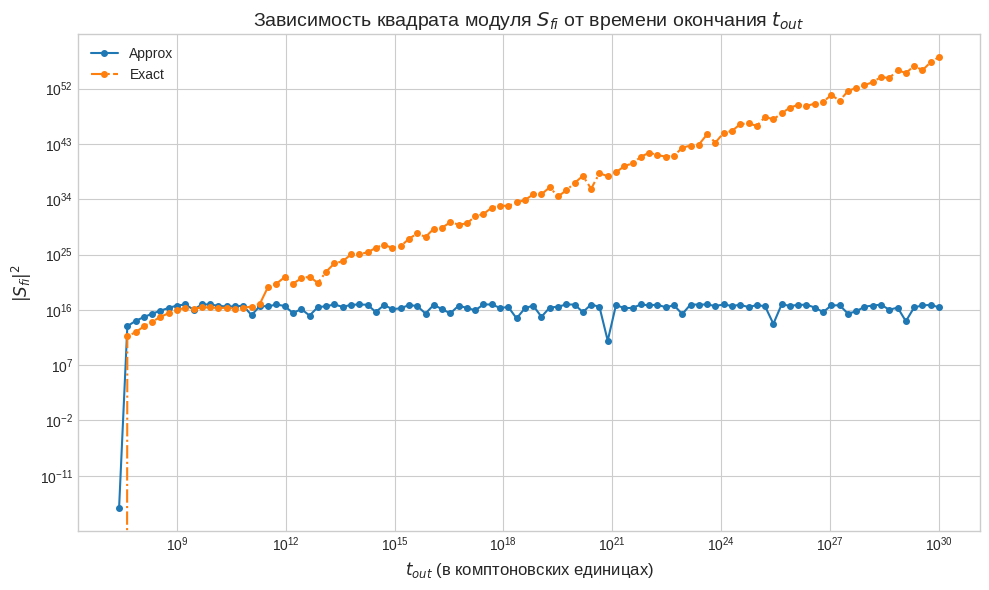

In [ ]:
def plot_Sfi_vs_tout(
    # Фиксированные параметры для Sfi
    si, li, pzi, sf, lf, pzf, kp, phi_k, lambda_, t_in,
    # Параметры для оси t_out
    tout_start, tout_end, num_points=300
):
    """
    Строит график зависимости |S_fi|^2 от t_out.

    Args:
        ... все параметры функции Sfi_wide_Texact, кроме t_out ...
        tout_start (float): Начальное значение для t_out.
        tout_end (float): Конечное значение для t_out.
        num_points (int): Количество точек на графике.
    """
    # Создаем массив значений t_out на логарифмической шкале
    # Это хорошо подходит для величин, меняющихся на порядки
    tout_values = np.logspace(
        np.log10(tout_start),
        np.log10(tout_end),
        num=num_points
    )

    # Список для хранения результатов |S_fi|^2
    sfi_Texact_sq_mod_values = []
    sfi_sq_mod_values = []

    print(f"Вычисление |S_fi|^2 для {num_points} значений t_out от {tout_start:.2e} до {tout_end:.2e}...")

    # Проходим по всем значениям t_out и вычисляем S_fi
    for tout_val in tqdm(tout_values):
        # Преобразуем значение t_out в тензор PyTorch
        t_out_tensor = torch.tensor(tout_val, dtype=dtype, device=device)

        # Вычисляем S_fi
        sfi_Texact = Sfi_wide_Texact(si, li, pzi, sf, lf, pzf, kp, phi_k, lambda_, t_in, t_out_tensor)
        sfi = Sfi_wide(si, li, pzi, sf, lf, pzf, kp, phi_k, lambda_, t_in, t_out_tensor)

        # Вычисляем квадрат модуля и переводим в число Python для графика
        sfi_sq_mod = torch.abs(sfi)**2
        sfi_sq_mod_values.append(sfi_sq_mod.item())
        sfi_Texact_sq_mod = torch.abs(sfi_Texact)**2
        sfi_Texact_sq_mod_values.append(sfi_Texact_sq_mod.item())

    # Построение графика
    plt.style.use('seaborn-v0_8-whitegrid') # Стиль графика
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(tout_values, sfi_sq_mod_values, marker='o', linestyle='-', markersize=4)
    ax.plot(tout_values, sfi_Texact_sq_mod_values, marker='o', linestyle='-.', markersize=4)

    # Настройка осей и заголовка
    ax.set_xscale('log') # Логарифмическая шкала для t_out
    ax.set_yscale('log') # Логарифмическая шкала для |S_fi|^2, часто полезна

    ax.set_xlabel('$t_{out}$ (в комптоновских единицах)', fontsize=12)
    ax.set_ylabel('$|S_{fi}|^2$', fontsize=12)
    ax.set_title('Зависимость квадрата модуля $S_{fi}$ от времени окончания $t_{out}$', fontsize=14)

    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()
    ax.legend(['Approx', 'Exact'])
    plt.show()


# --- ЗАПУСК ПОСТРОЕНИЯ ГРАФИКА ---

# Используйте ваши "стандартные" значения параметров
# Укажите диапазон для t_out. Например, от t_in до значения на 3 порядка больше.
tout_start_val = t_in.item()
#tout_start_val = 1
tout_end_val = 1e30 # Например, в 1000 раз больше t_in

plot_Sfi_vs_tout(
    si=si, li=li, pzi=pzi,
    sf=sf, lf=lf, pzf=pzf,
    kp=kp, phi_k=phi_k, lambda_=lambda_,
    t_in=t_in,
    tout_start=tout_start_val,
    tout_end=tout_end_val,
    num_points=100  # Начните с небольшого числа точек для быстрой проверки
)

Вычисление Full Probability для 200 значений t_out от 2.56e+08 до 1.20e+20...


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/autoray/autoray.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchquad/integration/utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


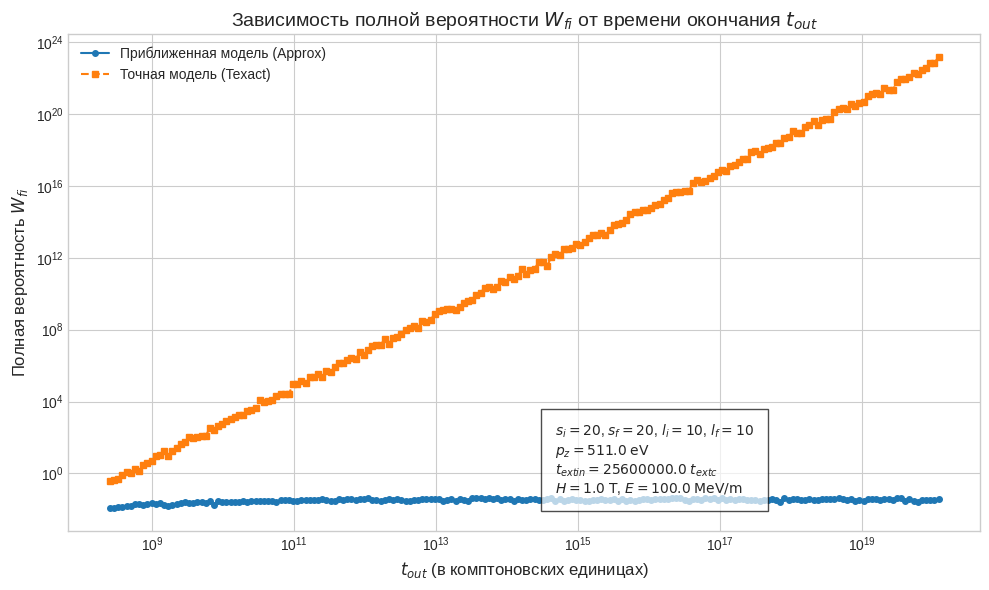

Вычисление Full Probability для 200 значений t_out от 5.12e+07 до 1.20e+20...


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/autoray/autoray.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchquad/integration/utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


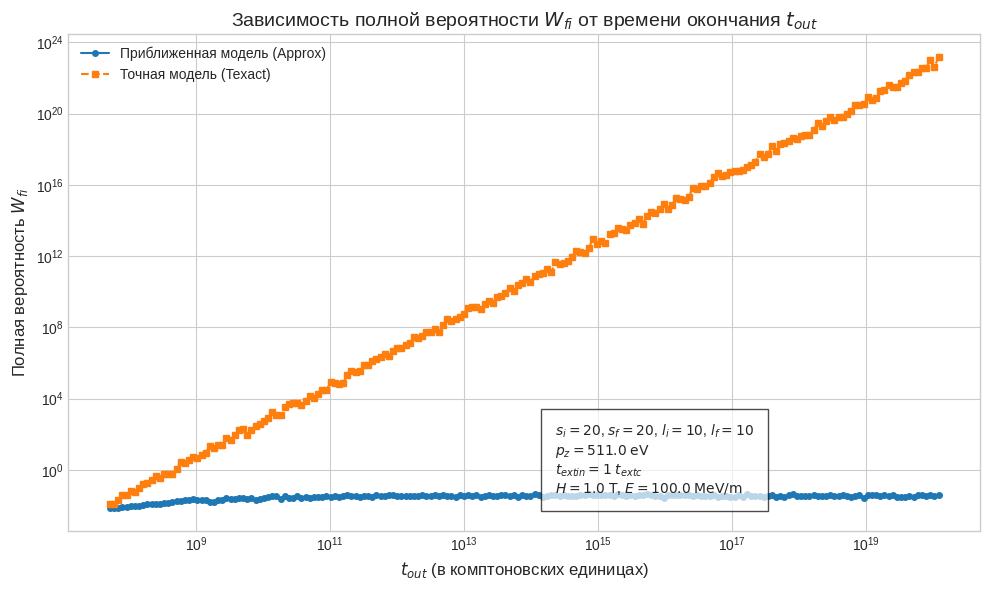

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # или from tqdm import tqdm



def plot_full_prob_vs_tout(
    # Фиксированные параметры для full_prob
    si, li, pzi, sf, lf, t_in, kp_max, pzf_min,
    # Параметры для оси t_out
    tout_start, tout_end, num_points=100
):
    """
    Строит график полной вероятности full_prob от t_out для двух моделей:
    приближенной (Approx) и точной (Texact).

    Args:
        ... все параметры функции full_prob, кроме t_out ...
        tout_start (float): Начальное значение для t_out.
        tout_end (float): Конечное значение для t_out.
        num_points (int): Количество точек на графике.
    """
    # Создаем массив значений t_out на логарифмической шкале
    if tout_start <= 0:
        raise ValueError("tout_start должен быть > 0 для логарифмической шкалы. Используйте np.geomspace.")

    tout_values = np.geomspace(tout_start, tout_end, num=num_points)

    # Списки для хранения результатов
    prob_values = []
    prob_texact_values = []

    print(f"Вычисление Full Probability для {num_points} значений t_out от {tout_start:.2e} до {tout_end:.2e}...")

    # Проходим по всем значениям t_out и вычисляем вероятности
    for tout_val in tqdm(tout_values):
        t_out_tensor = torch.tensor(tout_val, dtype=dtype, device=device)

        # Вычисляем приближенную вероятность
        prob = full_prob(si, li, pzi, sf, lf, t_in, t_out_tensor, kp_max, pzf_min)
        prob_values.append(prob.item())

        # Вычисляем "точную" вероятность
        prob_texact = full_prob_Texact(si, li, pzi, sf, lf, t_in, t_out_tensor, kp_max, pzf_min)
        prob_texact_values.append(prob_texact.item())

    # Построение графика
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(tout_values, prob_values, 'o-', markersize=4, label='Приближенная модель (Approx)')
    ax.plot(tout_values, prob_texact_values, 's--', markersize=4, label='Точная модель (Texact)')

    # Настройка осей и заголовка
    ax.set_xscale('log')
    ax.set_yscale('log') # Логарифмическая шкала для вероятности тоже часто полезна

    ax.set_xlabel('$t_{out}$ (в комптоновских единицах)', fontsize=12)
    ax.set_ylabel('Полная вероятность $W_{fi}$', fontsize=12)
    ax.set_title('Зависимость полной вероятности $W_{fi}$ от времени окончания $t_{out}$', fontsize=14)

    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.legend() # Добавляем легенду
    plt.tight_layout()

    label = f"$s_i={si}$, $s_f={sf}$, $l_i={li}$, $l_f={lf}$\n$p_z={pzi * 0.511e6}$ $\\text{{eV}}$\n$t_{{\text{{in}}}}={t_in}$ $t_{{\text{{c}}}}$\n$H = {HtoHc / 2.27e-10}$ $\\text{{T}}$, $E = {F0 / 7.57e-8 * 100}$ $\\text{{MeV/m}}$"
    plt.figtext(0.56, 0.17, label, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})

    plt.show()


# --- ЗАПУСК ПОСТРОЕНИЯ ГРАФИКА ---

# Задайте параметры, необходимые для вычисления полных вероятностей
pzi = torch.tensor(1e-3, dtype=dtype, device=device) # Продольный импульс начального электрона: 0.196 -> 100keV
kp_max = torch.tensor(1e-4, dtype=dtype, device=device)   # Пример: максимальный поперечный импульс
pzf_min = pzi.item() - F0 * sigma # Пример: минимальный конечный продольный импульс
si = 20
sf = 20
li = 10
lf = 10

# Укажите диапазон для t_out
# Важно: tout_start должен быть больше t_in!
t_in = torch.tensor(2.56e7, dtype=dtype, device=device)
tout_start_val = torch.tensor(2.56e8, dtype=dtype, device=device) # Начинаем чуть позже t_in
tout_end_val = torch.tensor(1.2e20, dtype=dtype, device=device) # Задайте большое конечное время

plot_full_prob_vs_tout(
    si=si, li=li, pzi=pzi,
    sf=sf, lf=lf,
    t_in=t_in,
    kp_max=kp_max,
    pzf_min=pzf_min,
    tout_start=tout_start_val,
    tout_end=tout_end_val,
    num_points=200  # Начните с небольшого числа точек для быстрой проверки
)

plot_full_prob_vs_tout(
    si=si, li=li, pzi=pzi,
    sf=sf, lf=lf,
    t_in=1,
    kp_max=kp_max,
    pzf_min=pzf_min,
    tout_start=t_in * 2,
    tout_end=tout_end_val,
    num_points=200  # Начните с небольшого числа точек для быстрой проверки
)


# Графики

## Двойная дифференциальная вероятность $\frac{d W}{d p_z' d k_{\perp}}$

In [ ]:
print(si, 10, pzi, sf, 0, pzf, phi_k, lambda_, t_in, t_out)

In [ ]:
ks = torch.linspace(1e-10,1e-4,10000)
k_ticks = np.linspace(0,1e-4,10)
k_ticks_ev = np.round(np.linspace(0,1e-4 * 0.511 * 10**6, 10), 2)
li = 33
lf = 33
pzf = torch.tensor(0.1959)
t_in = torch.tensor(1.32e8)
t_out = torch.tensor(2.59e10)

plt.figure()
check = ks*abs(Sfi_wide_sm(si, li, pzi, sf, lf, pzf, ks, phi_k, lambda_, t_in, t_out))**2
check2 = apply_savgol_filter_to_tensor(
        ks * torch.abs(Sfi_wide(si, li, pzi, sf, lf, pzf, kp, phi_k, lambda_, t_in, t_out))**2, 20)
check3 = apply_savgol_filter_to_tensor(ks*abs(Sfi_wide(si, li, pzi, sf, lf, pzf, ks, phi_k, lambda_, t_in, t_out))**2, 20)
#plt.plot(ks, check, label='123')
#plt.plot(ks, check2, label='123')
plt.plot(ks, check3, label='123')
plt.xlabel("$k_{\perp} (eV)$", fontsize = 16)
#plt.xticks(k_ticks, k_ticks_ev, rotation=0)
plt.ylabel(r"$\frac{d^2 W}{d p_z^{\prime} d k_{\perp}} (m_e^{-2})$", rotation=90, fontsize = 16, labelpad=10)
plt.title("Double-differential probability")
plt.grid()
label = f"$s_i={si}$\n$l_i= 10$\n$p_z={pzi}$\n$s_f={sf}$\n$p_z'={pzf}$\n$\phi = 0$\n$\lambda={lambda_}$\n$t_{{in}}=10^{{-6}}$\n$t_{{out}}=2.59 \cdot 10^{{10}}$"
plt.figtext(0.7, 0.3, label, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})

legend = plt.legend(frameon=True)

# Настроим цвет фона и рамки легенды
legend.get_frame().set_facecolor('white')      # белый фон
legend.get_frame().set_edgecolor('black')      # черная рамка
legend.get_frame().set_linewidth(1.0)          # толщина рамки

plt.show()
unf = ks*abs(Sfi_wide(si, li, pzi, sf, lf, pzf, ks, phi_k, lambda_, t_in, t_out))**2

plt.figure()
plt.plot(ks, unf)

In [ ]:
k123 = torch.tensor(1e-4)
k123*abs(Sfi_wide(si, 100, pzi, sf, 100, pzf, k123, phi_k, lambda_, t_in, t_out))**2

In [ ]:
ks*abs(Sfi_wide(si, li, pzi, sf, lf, pzf, ks, phi_k, lambda_, t_in, t_out))**2

## Дифференциальная вероятность $\frac{d W}{d p_z'}$

In [ ]:
pzi - sigma * F0 / 10000

In [ ]:
F0*sigma

In [ ]:
# pzf_max_ = pzi.item()
# pzf_min_ = pzf_min.item()
pzf_min_ = 0.19570
pzf_max_ = pzi + 0.00003
pzs = np.linspace(pzf_min_, pzf_max_, 100)

li = 10

pzf_min_ticks = pzf_min_.item() if torch.is_tensor(pzf_min_) else pzf_min_
pzf_max_ticks = pzf_max_.item() if torch.is_tensor(pzf_max_) else pzf_max_
pz_ticks = np.round(np.linspace(pzf_min_ticks, pzf_max_ticks, 11), 5)
#pz_ticks_ev = np.round(np.linspace(pzf_min * 0.511 * 10**6, pzf_max * 0.511 * 10**6, 11), 2)

plt.figure()
cmap = plt.get_cmap('magma')
for lf in range(5, 6):
    check = smooth_wavelet([dW_dpzf_unpol_wide_sm(si, li, pzi, sf, lf, pz, t_in, t_out, kp_max) for pz in pzs], sigma=5) / 0.511
    #check2 = smooth_wavelet([dW_dpzf_unpol_wide_sm_old(si, 10, pzi, sf, lf, pz, t_in, t_out, kp_max) for pz in pzs], sigma=5)
    plt.plot(pzs, check, label=f'$l_f={lf}$')
    #plt.plot(pzs, check2, label=f'$l_f={lf}$')
    plt.yscale("log")
    plt.xlabel(f"$p_z' (\\text{{MeV}})$", fontsize = 16)
    plt.xticks(pz_ticks, np.round(pz_ticks * 0.511, 5), rotation=90)
    plt.ylabel(r"$\frac{d W}{d p_z^{\prime}} (\text{MeV}^{-1})$", rotation=90, fontsize = 16, labelpad=5)
    plt.title("Differential probability of photon emission")
    plt.grid()

    # label = f"$p_z={pzi} (m_e)$\n$s_i={si}$, $l_i= 10$, $s_f={sf}$\n$t_{{in}}=10^{{-6}} s$\n$t_{{out}}=3.3 \cdot 10^{{-11}} s$"




    # # Настроим цвет фона и рамки легенды
    # legend.get_frame().set_facecolor('white') # белый фон
    # legend.get_frame().set_edgecolor('black') # черная рамка
    # legend.get_frame().set_linewidth(1.0) # толщина рамки

label = f"$H = 1$ $\\text{{T}}$, $E = 100$ $\\text{{MeV/m}}$\n$s_i={si}$, $l_i= {li}$, $s_f={sf}$\n$t_{{out}}=33 \\text{{ps}}$ $(1 \\text{{cm}})$"
plt.figtext(0.62, 0.28, label, fontsize=9, bbox={'facecolor': 'white', 'alpha': 0.6, 'pad': 5})

# plt.ylim(10**-5, 10**-1)
plt.axvline(x=pzi, color='black', linestyle='--', label=f'$p_z = {pzi} (m_{{e}})$')
legend = plt.legend(frameon=True)
plt.tight_layout()
plt.show()

In [ ]:
print(sigma * F0 * 1000)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch


pzi = torch.tensor(0.196, dtype=dtype, device=device) # Продольный импульс начального электрона: 0.196 -> 100keV
si = 1
li = 10
sf = 1
lf = 1


F0 = torch.tensor(7.57e-8, dtype=dtype, device=device) # Сила со стороны электрического поля на заряд: 7.57e-8 -> 100 MeV/m
# t_C = 1.287e-21 s
# lambda_C = 3.86e-13 m
t_in = torch.tensor(2.56e7, dtype=dtype, device=device) # Время начала наблюдения: 2.56e7 t_c = 3.3e-8 s (соответствует расстоянию в 10 мкм при v = c)
t_out = torch.tensor(2.56e10, dtype=dtype, device=device) # Время пролёта ускорителя: 2.56e10 t_c = 3.3e-11 s (соответствует расстоянию в 1 см при v = c)
# H_c = 4.41e9 T
HtoHc = torch.tensor(1e-6, dtype=dtype, device=device) # Величина магнитного поля: 2.27e-10 -> 1T
rho_H = 2.0 / torch.sqrt(HtoHc) # Магнитная длина: для H = 1 T магнитная длина 132 744 комптоновских длин волн или 5.12e-8 m = 0.512 nm
# 1 / rho_H соответствует импульсу 7.53e-6 или 3.85 eV

kp_max = 2 / rho_H # Верхний предел интегрирования по величине поперечного импульса фотона: 1e-4 -> 51.1 eV
# kp_max должен быть заметно больше 1 / rho_H


# --- ВАШ КОД С ИЗМЕНЕННОЙ ОСЬЮ X ---

# 1. Ваши исходные данные и вычисления (без изменений)
pzf_min_ = 0.19550
pzf_max_ = pzi + 0.00005
pzs = np.linspace(pzf_min_, pzf_max_, 100)

# --- НАЧАЛО: Блок с вашими переменными и функциями ---
# Этот блок должен быть уже выполнен в вашем ноутбуке.
# Я добавляю "заглушки" только для того, чтобы код был автономно исполняемым.
# УБЕДИТЕСЬ, ЧТО ВАШИ РЕАЛЬНЫЕ ПЕРЕМЕННЫЕ И ФУНКЦИИ ОПРЕДЕЛЕНЫ!

try:
    pzi, si, li, sf, t_in, t_out, kp_max
except NameError:
    print("Внимание: используются переменные-заглушки. Убедитесь, что ваши реальные переменные определены.")
    pzi = 0.19597
    si, li, sf, t_in, t_out, kp_max = 1, 10, 1, 1e-6, 33e-12, 1.0
    def dW_dpzf_unpol_wide_sm(si, li, pzi, sf, lf, pz, t_in, t_out, kp_max):
        return np.exp(-((pz - (pzi - 0.0001))**2) / 1e-9) + 0.5 * np.exp(-((pz - (pzi - 0.0002))**2) / 1e-10)
    def smooth_wavelet(data, sigma):
        from scipy.ndimage import gaussian_filter1d
        return gaussian_filter1d(data, sigma=sigma)

# --- КОНЕЦ: Блока с вашими переменными и функциями ---


# --- ВАШ КОД С ИЗМЕНЕННОЙ ОСЬЮ X ---

# 1. Ваши исходные данные и вычисления (без изменений)
pzf_min_ = 0.19570
pzf_max_ = pzi + 0.00003
pzs = np.linspace(pzf_min_, pzf_max_, 100)
li = 10

# 2. Создаем фигуру для графика
plt.figure(figsize=(8, 6)) # Зададим размер для удобства

# 3. Выполняем преобразование данных для оси X
pzs_shifted = pzs - pzi

# Основной цикл построения
for lf in range(5, 6):
    print(kp_max)
    # Расчет Y-значений остается АБСОЛЮТНО таким же, как у вас
    check = smooth_wavelet([dW_dpzf_unpol_wide_sm(si, li, pzi, sf, lf, pz, t_in, t_out, kp_max) for pz in pzs], sigma=5) / 0.511 / 1e6
    print(check)
    # 4. Строим график, используя НОВЫЕ сдвинутые данные для оси X
    plt.plot(pzs_shifted, check, label=f'$l_f={lf}$')




HtoHc = torch.tensor(2.27e-10, dtype=dtype, device=device) # Величина магнитного поля: 2.27e-10 -> 1T
rho_H = 2.0 / torch.sqrt(HtoHc) # Магнитная длина: для H = 1 T магнитная длина 132 744 комптоновских длин волн или 5.12e-8 m = 0.512 nm
# 1 / rho_H соответствует импульсу 7.53e-6 или 3.85 eV

kp_max = torch.tensor(1e-4, dtype=dtype, device=device) # Верхний предел интегрирования по величине поперечного импульса фотона: 1e-4 -> 51.1 eV
# kp_max должен быть заметно больше 1 / rho_H
# for lf in range(5, 6):
#     # Расчет Y-значений остается АБСОЛЮТНО таким же, как у вас
#     check2 = smooth_wavelet([dW_dpzf_unpol_wide_sm(si, li, pzi, sf, lf, pz, t_in, t_out, kp_max) for pz in pzs], sigma=5) / 0.511 / 1e6
#     # 4. Строим график, используя НОВЫЕ сдвинутые данные для оси X
#     plt.plot(pzs_shifted, check2, label=f'$l_f={lf}$')

# Настройка осей и заголовка
plt.yscale("log")
# Подпись оси X остается той же, так как единицы измерения не изменились
plt.xlabel(f"$p_z' (\\text{{eV}})$", fontsize=16)
# 5. СЛОЖНАЯ СТРОКА С plt.xticks УДАЛЕНА. Matplotlib справится сам.
plt.ylabel(r"$\frac{d W}{d p_z^{\prime}} (\text{eV}^{-1})$", rotation=90, fontsize=16, labelpad=5)
plt.title("Differential probability of photon emission")
plt.grid(True)


tick_locations = plt.xticks()[0]

# 2. Задаем ваш множитель
scaling_factor = 0.511 * 1e6

# 3. Создаем НОВЫЕ ТЕКСТОВЫЕ метки.
# Мы проходимся по каждому числовому положению, умножаем его на ваш коэффициент
# и форматируем в строку с 5 знаками после запятой.
new_labels = [f'{loc * scaling_factor:.2f}' for loc in tick_locations]

# 4. Применяем новые метки и поворот в 30 градусов
# Мы указываем, в каких 'locations' нужно разместить наши новые текстовые 'labels'.
# ha='right' (horizontal alignment) - выравнивание по правому краю, что красиво смотрится при повороте.
plt.xticks(ticks=tick_locations, labels=new_labels, rotation=30, ha='right')


# Текстовый блок с параметрами (без изменений)
label = f"$H = 1$ $\\text{{T}}$, $E = 100$ $\\text{{MeV/m}}$\n$s_i={si}$, $l_i= {li}$, $s_f={sf}$\n$t_{{out}}=33$ $\\text{{ps}}$ $(1 \\text{{cm}})$"
plt.figtext(0.62, 0.28, label, fontsize=10, bbox={'facecolor': 'white', 'alpha': 0.6, 'pad': 10})

# 6. Вертикальная линия теперь рисуется в точке x=0
#plt.axvline(x=0, color='black', linestyle='--') # Убрал label, чтобы не мешался в легенде

plt.axvline(x=0, color='black', linestyle='--', label=f'$p_z = {pzi * 0.511:.6f}$ MeV')

# 7. ДОБАВЛЯЕМ АННОТАЦИЮ ПРЕОБРАЗОВАНИЯ
# Находим относительное положение нуля на оси, чтобы точно разместить текст под ним
min_shifted, max_shifted = pzs_shifted.min(), pzs_shifted.max()
zero_position_on_axis = (0 - min_shifted) / (max_shifted - min_shifted)
# Размещаем текст с исходным значением pzi под новой нулевой отметкой
plt.figtext(zero_position_on_axis, 0.01, f'+{pzi * 0.511:.6f} $\\text{{MeV}}$', ha='center', fontsize=10)


plt.xlim(left=1.01*pzs_shifted.min(), right=1.1*pzs_shifted.max())

# Легенда и отображение графика
legend = plt.legend(frameon=True)
plt.tight_layout()
# Немного сдвигаем нижнюю границу, чтобы текст аннотации точно поместился
plt.subplots_adjust(bottom=0.15)
plt.show()

In [ ]:
# pzf_max_ = pzi.item()
# pzf_min_ = pzf_min.item()
pzf_min_ = 0.19585
pzf_max_ = pzi
pzs = np.linspace(pzf_min_, pzf_max_, 100)

pz_ticks = np.round(np.linspace(pzf_min_, pzf_max_, 11), 5)
#pz_ticks_ev = np.round(np.linspace(pzf_min * 0.511 * 10**6, pzf_max * 0.511 * 10**6, 11), 2)

plt.figure()
cmap = plt.get_cmap('magma')
for sf in range(5, 15):
    check = smooth_wavelet([dW_dpzf_unpol_wide_sm(10, 3, pzi, sf, 3, pz, t_in, t_out, kp_max) for pz in pzs], sigma=5)
    #check2 = smooth_wavelet([dW_dpzf_unpol_wide_sm_old(si, 10, pzi, sf, lf, pz, t_in, t_out, kp_max) for pz in pzs], sigma=5)
    plt.plot(pzs, check, label=f'$s_f={sf}$')
    #plt.plot(pzs, check2, label=f'$l_f={lf}$')
    plt.xlabel("$p_z' (m_e)$", fontsize = 16)
    #plt.xticks(pz_ticks, pz_ticks, rotation=90)
    plt.ylabel(r"$\frac{d W}{d p_z^{\prime}} (m_e^{-1})$", rotation=90, fontsize = 16, labelpad=10)
    plt.title("Differential probability")
    plt.grid()

    label = f"$p_z={pzi} (m_e)$\n$s_i=10$, $l_i= 3$, $l_f=3$\n$t_{{in}}=10^{{-6}} s$\n$t_{{out}}=2.59 \cdot 10^{{10}} s$"
    plt.figtext(0.32, 0.65, label, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})



    # Настроим цвет фона и рамки легенды
    legend.get_frame().set_facecolor('white') # белый фон
    legend.get_frame().set_edgecolor('black') # черная рамка
    legend.get_frame().set_linewidth(1.0) # толщина рамки
# plt.ylim(10**-5, 10**-1)
plt.axvline(x=pzi, color='black', linestyle='--', label=f'$p_z = {pzi}$')
legend = plt.legend(frameon=True)
plt.tight_layout()
plt.show()

## Полная вероятность

In [ ]:
pzf_max_ = pzi
pzf_min_ = 0.187
pzs = np.linspace(pzf_min_, pzf_max_, 100)

for lf in range(5, 6):
    plt.plot(pzs, [full_prob(1, 10, pzi, 1, lf, 10/F0, t_out, 1e-4, pzmin - 0.009) for pzmin in pzs])
    plt.xlabel("$p_z' (m_e)$", fontsize = 16)
    plt.ylabel(r"$W$", rotation=90, fontsize = 16, labelpad=10)
    plt.title("Full probability")
    plt.grid()
    plt.yscale("log")

    # label = f"$p_z={pzi} (m_e)$\n$s_i={si}$, $l_i= 10$, $s_f={sf}$\n$t_{{in}}=10^{{-6}} s$\n$t_{{out}}=2.59 \cdot 10^{{10}} s$"
    # plt.figtext(0.32, 0.65, label, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})



    # # Настроим цвет фона и рамки легенды
    # legend.get_frame().set_facecolor('white') # белый фон
    # legend.get_frame().set_edgecolor('black') # черная рамка
    # legend.get_frame().set_linewidth(1.0) # толщина рамки

# plt.ylim(10**-5, 10**-1)
plt.axvline(x=pzi, color='black', linestyle='--', label=f'$p_z = {pzi}$')
legend = plt.legend(frameon=True)
plt.tight_layout()
plt.show()

In [ ]:
pzf_min = pzi - 10 * F0 * sigma
print(li, lf, t_in, t_out, pzi - pzf_min)
print(full_prob(si, 10, pzi, sf, 11, t_in, t_out, kp_max, pzf_min))
#def full_prob(si, li, pzi, sf, lf, t_in, t_out, kp_max, pzf_min):

In [ ]:
dW_dpzf_unpol_wide_sm(si, 10, pzi, sf, 11,pzf_min + (pzi - pzf_min)/2, t_in, t_out, kp_max)

In [ ]:
# Для постера --- поле 1e-2 от критического

HtoHc = torch.tensor(2.27e-11, dtype=dtype, device=device) # Величина магнитного поля: 2.27e-10 -> 1T
rho_H = 2.0 / torch.sqrt(HtoHc)
kp_max = 10 / rho_H
F0 = torch.tensor(7.57e-8, dtype=dtype, device=device) # 100 MV / m
pzi = torch.tensor(1e-3, dtype=dtype, device=device)
pzf_min = pzi - F0 * sigma
pzf_max = pzi

si = 20
li = 1
sf = 20
lf = 1
t_in = 10 / F0
t_out = torch.tensor(2.56e14, dtype=dtype, device=device) # 100 m

full_prob_li_lf_1_Hc = []
full_prob_li_lf_2_Hc = []
full_prob_li_lf_3_Hc = []
full_prob_li_lf_4_Hc = []
full_prob_li_lf_5_Hc = []
full_prob_li_lf_6_Hc = []
full_prob_li_lf_7_Hc = []
full_prob_si_sf_1_li_lf_1_Hc = []
full_prob_si_sf_2_li_lf_0_Hc = []
full_prob_si_sf_1_li_lf_4_Hc = []
full_prob_si_sf_2_li_lf_3_Hc = []
full_prob_si_sf_1_li_lf_0_Hc = []
full_prob_si_sf_2_li_lf_m1_Hc = []

#lf_arr = [i for i in range(1, 80)]
lf_arr = [i for i in range(1, 101, 5)]


darkbrown = '#654321'
darkorange = '#FF8C00'

plt.figure()
for lf in tqdm(lf_arr, desc="Integrating", colour="green"):
    full_prob_li_lf_1_Hc.append(full_prob(si, lf + 1, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_2_Hc.append(full_prob(si, lf + 2, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_3_Hc.append(full_prob(si, lf + 3, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_4_Hc.append(full_prob(si, lf + 4, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_5_Hc.append(full_prob(si, lf + 5, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_6_Hc.append(full_prob(si, lf + 6, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_7_Hc.append(full_prob(si, lf + 7, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_1_li_lf_1_Hc.append(full_prob(sf+1, lf + 1, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_2_li_lf_0_Hc.append(full_prob(sf+2, lf, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_1_li_lf_4_Hc.append(full_prob(sf+1, lf + 4, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_2_li_lf_3_Hc.append(full_prob(sf+2, lf + 3, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_1_li_lf_0_Hc.append(full_prob(sf+1, lf, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_2_li_lf_m1_Hc.append(full_prob(sf+2, lf - 1, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
plt.plot(lf_arr, full_prob_li_lf_1_Hc, label='$li - lf = 1$', color = 'black')
plt.plot(lf_arr, full_prob_li_lf_2_Hc, label='$li - lf = 2$', color = 'red')
plt.plot(lf_arr, full_prob_li_lf_3_Hc, label='$li - lf = 3$', color = 'blue')
plt.plot(lf_arr, full_prob_li_lf_4_Hc, label='$li - lf = 4$', color = 'lightgreen')
plt.plot(lf_arr, full_prob_li_lf_5_Hc, label='$li - lf = 5$', color = darkbrown)
plt.plot(lf_arr, full_prob_li_lf_6_Hc, label='$li - lf = 6$', color = 'magenta')
plt.plot(lf_arr, full_prob_li_lf_7_Hc, label='$li - lf = 7$', color = darkorange)
plt.plot(lf_arr, full_prob_si_sf_1_li_lf_1_Hc, label='$si - sf = 1, li - lf = 1$', color = 'red', linestyle = '--')
plt.plot(lf_arr, full_prob_si_sf_2_li_lf_0_Hc, label='$si - sf = 2, li - lf = 0$', color = 'red', linestyle = '-.')
plt.plot(lf_arr, full_prob_si_sf_1_li_lf_4_Hc, label='$si - sf = 1, li - lf = 4$', color = darkbrown, linestyle = '--')
plt.plot(lf_arr, full_prob_si_sf_2_li_lf_3_Hc, label='$si - sf = 2, li - lf = 3$', color = darkbrown, linestyle = '-.')
plt.plot(lf_arr, full_prob_si_sf_1_li_lf_0_Hc, label='$si - sf = 1, li - lf = 0$', color = 'black', linestyle = '-.')
plt.plot(lf_arr, full_prob_si_sf_2_li_lf_m1_Hc, label='$si - sf = 2, li - lf = -1$', color = 'blue', linestyle = '-.')

#plt.xlabel("$k_{\perp} (eV)$", fontsize = 16)
#plt.xticks(k_ticks, k_ticks_ev, rotation=0)
plt.yscale("log")
plt.ylabel(r"$W$", fontsize = 16, labelpad=10)
plt.xlabel(r"$l_f$", fontsize = 16, labelpad=10)
plt.title("Probability of photon emission")
plt.grid()
label = f"$s_i={si}$, $s_f={sf}$\n$p_z={pzi * 0.511 * 1000}$ $\\text{{keV}}$\n$t_{{out}}=0.33$ $\mu \\text{{s}}$\n$H = 0.1 \\text{{T}}$, $E = 100$ $\\text{{MeV/m}}$"
plt.figtext(0.56, 0.17, label, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})

legend = plt.legend(bbox_to_anchor=(0.0, 1.0), loc='upper left', frameon=True)

# Настроим цвет фона и рамки легенды
legend.get_frame().set_facecolor('white')      # белый фон
legend.get_frame().set_edgecolor('black')      # черная рамка
legend.get_frame().set_linewidth(1.0)          # толщина рамки

plt.show()

In [ ]:
# Для постера --- поле 1e-2 от критического

HtoHc = torch.tensor(2.27e-10, dtype=dtype, device=device) # Величина магнитного поля: 2.27e-10 -> 1T
rho_H = 2.0 / torch.sqrt(HtoHc)
kp_max = 10 / rho_H
F0 = torch.tensor(7.57e-8, dtype=dtype, device=device) # 100 MV / m
pzi = torch.tensor(1e-3, dtype=dtype, device=device)
pzf_min = pzi - F0 * sigma
pzf_max = pzi

si = 20
li = 1
sf = 20
lf = 1
t_in = 10 / F0
t_out = torch.tensor(2.56e14, dtype=dtype, device=device) # 100 m

full_prob_li_lf_1_Hc = []
full_prob_li_lf_2_Hc = []
full_prob_li_lf_3_Hc = []
full_prob_li_lf_4_Hc = []
full_prob_li_lf_5_Hc = []
full_prob_li_lf_6_Hc = []
full_prob_li_lf_7_Hc = []
full_prob_si_sf_1_li_lf_1_Hc = []
full_prob_si_sf_2_li_lf_0_Hc = []
full_prob_si_sf_1_li_lf_4_Hc = []
full_prob_si_sf_2_li_lf_3_Hc = []
full_prob_si_sf_1_li_lf_0_Hc = []
full_prob_si_sf_2_li_lf_m1_Hc = []

#lf_arr = [i for i in range(1, 80)]
lf_arr = [i for i in range(1, 101, 5)]


darkbrown = '#654321'
darkorange = '#FF8C00'

plt.figure()
for lf in tqdm(lf_arr, desc="Integrating", colour="green"):
    full_prob_li_lf_1_Hc.append(full_prob(si, lf + 1, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_2_Hc.append(full_prob(si, lf + 2, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_3_Hc.append(full_prob(si, lf + 3, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_4_Hc.append(full_prob(si, lf + 4, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_5_Hc.append(full_prob(si, lf + 5, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_6_Hc.append(full_prob(si, lf + 6, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_7_Hc.append(full_prob(si, lf + 7, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_1_li_lf_1_Hc.append(full_prob(sf+1, lf + 1, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_2_li_lf_0_Hc.append(full_prob(sf+2, lf, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_1_li_lf_4_Hc.append(full_prob(sf+1, lf + 4, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_2_li_lf_3_Hc.append(full_prob(sf+2, lf + 3, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_1_li_lf_0_Hc.append(full_prob(sf+1, lf, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_2_li_lf_m1_Hc.append(full_prob(sf+2, lf - 1, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
plt.plot(lf_arr, full_prob_li_lf_1_Hc, label='$li - lf = 1$', color = 'black')
plt.plot(lf_arr, full_prob_li_lf_2_Hc, label='$li - lf = 2$', color = 'red')
plt.plot(lf_arr, full_prob_li_lf_3_Hc, label='$li - lf = 3$', color = 'blue')
plt.plot(lf_arr, full_prob_li_lf_4_Hc, label='$li - lf = 4$', color = 'lightgreen')
plt.plot(lf_arr, full_prob_li_lf_5_Hc, label='$li - lf = 5$', color = darkbrown)
plt.plot(lf_arr, full_prob_li_lf_6_Hc, label='$li - lf = 6$', color = 'magenta')
plt.plot(lf_arr, full_prob_li_lf_7_Hc, label='$li - lf = 7$', color = darkorange)
plt.plot(lf_arr, full_prob_si_sf_1_li_lf_1_Hc, label='$si - sf = 1, li - lf = 1$', color = 'red', linestyle = '--')
plt.plot(lf_arr, full_prob_si_sf_2_li_lf_0_Hc, label='$si - sf = 2, li - lf = 0$', color = 'red', linestyle = '-.')
plt.plot(lf_arr, full_prob_si_sf_1_li_lf_4_Hc, label='$si - sf = 1, li - lf = 4$', color = darkbrown, linestyle = '--')
plt.plot(lf_arr, full_prob_si_sf_2_li_lf_3_Hc, label='$si - sf = 2, li - lf = 3$', color = darkbrown, linestyle = '-.')
plt.plot(lf_arr, full_prob_si_sf_1_li_lf_0_Hc, label='$si - sf = 1, li - lf = 0$', color = 'black', linestyle = '-.')
plt.plot(lf_arr, full_prob_si_sf_2_li_lf_m1_Hc, label='$si - sf = 2, li - lf = -1$', color = 'blue', linestyle = '-.')

#plt.xlabel("$k_{\perp} (eV)$", fontsize = 16)
#plt.xticks(k_ticks, k_ticks_ev, rotation=0)
plt.yscale("log")
plt.ylabel(r"$W$", fontsize = 16, labelpad=10)
plt.xlabel(r"$l_f$", fontsize = 16, labelpad=10)
plt.title("Probability of photon emission")
plt.grid()
label = f"$s_i={si}$, $s_f={sf}$\n$p_z={pzi * 0.511 * 1000}$ $\\text{{keV}}$\n$t_{{out}}=0.33$ $\mu \\text{{s}}$\n$H = 1 \\text{{T}}$, $E = 100$ $\\text{{MeV/m}}$"
plt.figtext(0.56, 0.17, label, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})

legend = plt.legend(bbox_to_anchor=(0.0, 1.0), loc='upper left', frameon=True)

# Настроим цвет фона и рамки легенды
legend.get_frame().set_facecolor('white')      # белый фон
legend.get_frame().set_edgecolor('black')      # черная рамка
legend.get_frame().set_linewidth(1.0)          # толщина рамки

plt.show()

In [ ]:
# Для постера --- поле 1e-2 от критического

HtoHc = torch.tensor(2.27e-9, dtype=dtype, device=device) # Величина магнитного поля: 2.27e-10 -> 1T
rho_H = 2.0 / torch.sqrt(HtoHc)
kp_max = 10 / rho_H
F0 = torch.tensor(7.57e-8, dtype=dtype, device=device) # 100 MV / m
pzi = torch.tensor(1e-3, dtype=dtype, device=device)
pzf_min = pzi - F0 * sigma
pzf_max = pzi

si = 20
li = 1
sf = 20
lf = 1
t_in = 10 / F0
t_out = torch.tensor(2.56e14, dtype=dtype, device=device) # 100 m

full_prob_li_lf_1_Hc = []
full_prob_li_lf_2_Hc = []
full_prob_li_lf_3_Hc = []
full_prob_li_lf_4_Hc = []
full_prob_li_lf_5_Hc = []
full_prob_li_lf_6_Hc = []
full_prob_li_lf_7_Hc = []
full_prob_si_sf_1_li_lf_1_Hc = []
full_prob_si_sf_2_li_lf_0_Hc = []
full_prob_si_sf_1_li_lf_4_Hc = []
full_prob_si_sf_2_li_lf_3_Hc = []
full_prob_si_sf_1_li_lf_0_Hc = []
full_prob_si_sf_2_li_lf_m1_Hc = []

#lf_arr = [i for i in range(1, 80)]
lf_arr = [i for i in range(1, 101, 5)]


darkbrown = '#654321'
darkorange = '#FF8C00'

plt.figure()
for lf in tqdm(lf_arr, desc="Integrating", colour="green"):
    full_prob_li_lf_1_Hc.append(full_prob(si, lf + 1, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_2_Hc.append(full_prob(si, lf + 2, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_3_Hc.append(full_prob(si, lf + 3, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_4_Hc.append(full_prob(si, lf + 4, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_5_Hc.append(full_prob(si, lf + 5, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_6_Hc.append(full_prob(si, lf + 6, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_7_Hc.append(full_prob(si, lf + 7, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_1_li_lf_1_Hc.append(full_prob(sf+1, lf + 1, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_2_li_lf_0_Hc.append(full_prob(sf+2, lf, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_1_li_lf_4_Hc.append(full_prob(sf+1, lf + 4, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_2_li_lf_3_Hc.append(full_prob(sf+2, lf + 3, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_1_li_lf_0_Hc.append(full_prob(sf+1, lf, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_2_li_lf_m1_Hc.append(full_prob(sf+2, lf - 1, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
plt.plot(lf_arr, full_prob_li_lf_1_Hc, label='$li - lf = 1$', color = 'black')
plt.plot(lf_arr, full_prob_li_lf_2_Hc, label='$li - lf = 2$', color = 'red')
plt.plot(lf_arr, full_prob_li_lf_3_Hc, label='$li - lf = 3$', color = 'blue')
plt.plot(lf_arr, full_prob_li_lf_4_Hc, label='$li - lf = 4$', color = 'lightgreen')
plt.plot(lf_arr, full_prob_li_lf_5_Hc, label='$li - lf = 5$', color = darkbrown)
plt.plot(lf_arr, full_prob_li_lf_6_Hc, label='$li - lf = 6$', color = 'magenta')
plt.plot(lf_arr, full_prob_li_lf_7_Hc, label='$li - lf = 7$', color = darkorange)
plt.plot(lf_arr, full_prob_si_sf_1_li_lf_1_Hc, label='$si - sf = 1, li - lf = 1$', color = 'red', linestyle = '--')
plt.plot(lf_arr, full_prob_si_sf_2_li_lf_0_Hc, label='$si - sf = 2, li - lf = 0$', color = 'red', linestyle = '-.')
plt.plot(lf_arr, full_prob_si_sf_1_li_lf_4_Hc, label='$si - sf = 1, li - lf = 4$', color = darkbrown, linestyle = '--')
plt.plot(lf_arr, full_prob_si_sf_2_li_lf_3_Hc, label='$si - sf = 2, li - lf = 3$', color = darkbrown, linestyle = '-.')
plt.plot(lf_arr, full_prob_si_sf_1_li_lf_0_Hc, label='$si - sf = 1, li - lf = 0$', color = 'black', linestyle = '-.')
plt.plot(lf_arr, full_prob_si_sf_2_li_lf_m1_Hc, label='$si - sf = 2, li - lf = -1$', color = 'blue', linestyle = '-.')

#plt.xlabel("$k_{\perp} (eV)$", fontsize = 16)
#plt.xticks(k_ticks, k_ticks_ev, rotation=0)
plt.yscale("log")
plt.ylabel(r"$W$", fontsize = 16, labelpad=10)
plt.xlabel(r"$l_f$", fontsize = 16, labelpad=10)
plt.title("Probability of photon emission")
plt.grid()
label = f"$s_i={si}$, $s_f={sf}$\n$p_z={pzi * 0.511 * 1000}$ $\\text{{keV}}$\n$t_{{out}}=0.33$ $\mu \\text{{s}}$\n$H = 10 \\text{{T}}$, $E = 100$ $\\text{{MeV/m}}$"
plt.figtext(0.56, 0.17, label, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})

legend = plt.legend(bbox_to_anchor=(0.0, 1.0), loc='upper left', frameon=True)

# Настроим цвет фона и рамки легенды
legend.get_frame().set_facecolor('white')      # белый фон
legend.get_frame().set_edgecolor('black')      # черная рамка
legend.get_frame().set_linewidth(1.0)          # толщина рамки

plt.show()

In [ ]:
# Для постера --- поле 1e-2 от критического

HtoHc = torch.tensor(2.27e-8, dtype=dtype, device=device) # Величина магнитного поля: 2.27e-10 -> 1T
rho_H = 2.0 / torch.sqrt(HtoHc)
kp_max = 10 / rho_H
F0 = torch.tensor(7.57e-8, dtype=dtype, device=device) # 100 MV / m
pzi = torch.tensor(1e-3, dtype=dtype, device=device)
pzf_min = pzi - F0 * sigma
pzf_max = pzi

si = 20
li = 1
sf = 20
lf = 1
t_in = 10 / F0
t_out = torch.tensor(2.56e14, dtype=dtype, device=device) # 100 m

full_prob_li_lf_1_Hc = []
full_prob_li_lf_2_Hc = []
full_prob_li_lf_3_Hc = []
full_prob_li_lf_4_Hc = []
full_prob_li_lf_5_Hc = []
full_prob_li_lf_6_Hc = []
full_prob_li_lf_7_Hc = []
full_prob_si_sf_1_li_lf_1_Hc = []
full_prob_si_sf_2_li_lf_0_Hc = []
full_prob_si_sf_1_li_lf_4_Hc = []
full_prob_si_sf_2_li_lf_3_Hc = []
full_prob_si_sf_1_li_lf_0_Hc = []
full_prob_si_sf_2_li_lf_m1_Hc = []

#lf_arr = [i for i in range(1, 80)]
lf_arr = [i for i in range(1, 101, 5)]


darkbrown = '#654321'
darkorange = '#FF8C00'

plt.figure()
for lf in tqdm(lf_arr, desc="Integrating", colour="green"):
    full_prob_li_lf_1_Hc.append(full_prob(si, lf + 1, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_2_Hc.append(full_prob(si, lf + 2, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_3_Hc.append(full_prob(si, lf + 3, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_4_Hc.append(full_prob(si, lf + 4, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_5_Hc.append(full_prob(si, lf + 5, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_6_Hc.append(full_prob(si, lf + 6, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_li_lf_7_Hc.append(full_prob(si, lf + 7, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_1_li_lf_1_Hc.append(full_prob(sf+1, lf + 1, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_2_li_lf_0_Hc.append(full_prob(sf+2, lf, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_1_li_lf_4_Hc.append(full_prob(sf+1, lf + 4, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_2_li_lf_3_Hc.append(full_prob(sf+2, lf + 3, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_1_li_lf_0_Hc.append(full_prob(sf+1, lf, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
    full_prob_si_sf_2_li_lf_m1_Hc.append(full_prob(sf+2, lf - 1, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))
plt.plot(lf_arr, full_prob_li_lf_1_Hc, label='$li - lf = 1$', color = 'black')
plt.plot(lf_arr, full_prob_li_lf_2_Hc, label='$li - lf = 2$', color = 'red')
plt.plot(lf_arr, full_prob_li_lf_3_Hc, label='$li - lf = 3$', color = 'blue')
plt.plot(lf_arr, full_prob_li_lf_4_Hc, label='$li - lf = 4$', color = 'lightgreen')
plt.plot(lf_arr, full_prob_li_lf_5_Hc, label='$li - lf = 5$', color = darkbrown)
plt.plot(lf_arr, full_prob_li_lf_6_Hc, label='$li - lf = 6$', color = 'magenta')
plt.plot(lf_arr, full_prob_li_lf_7_Hc, label='$li - lf = 7$', color = darkorange)
plt.plot(lf_arr, full_prob_si_sf_1_li_lf_1_Hc, label='$si - sf = 1, li - lf = 1$', color = 'red', linestyle = '--')
plt.plot(lf_arr, full_prob_si_sf_2_li_lf_0_Hc, label='$si - sf = 2, li - lf = 0$', color = 'red', linestyle = '-.')
plt.plot(lf_arr, full_prob_si_sf_1_li_lf_4_Hc, label='$si - sf = 1, li - lf = 4$', color = darkbrown, linestyle = '--')
plt.plot(lf_arr, full_prob_si_sf_2_li_lf_3_Hc, label='$si - sf = 2, li - lf = 3$', color = darkbrown, linestyle = '-.')
plt.plot(lf_arr, full_prob_si_sf_1_li_lf_0_Hc, label='$si - sf = 1, li - lf = 0$', color = 'black', linestyle = '-.')
plt.plot(lf_arr, full_prob_si_sf_2_li_lf_m1_Hc, label='$si - sf = 2, li - lf = -1$', color = 'blue', linestyle = '-.')

#plt.xlabel("$k_{\perp} (eV)$", fontsize = 16)
#plt.xticks(k_ticks, k_ticks_ev, rotation=0)
plt.yscale("log")
plt.ylabel(r"$W$", fontsize = 16, labelpad=10)
plt.xlabel(r"$l_f$", fontsize = 16, labelpad=10)
plt.title("Probability of photon emission")
plt.grid()
label = f"$s_i={si}$, $s_f={sf}$\n$p_z={pzi * 0.511 * 1000}$ $\\text{{keV}}$\n$t_{{out}}=0.33$ $\mu \\text{{s}}$\n$H = 100 \\text{{T}}$, $E = 100$ $\\text{{MeV/m}}$"
plt.figtext(0.56, 0.17, label, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})

legend = plt.legend(bbox_to_anchor=(0.0, 1.0), loc='upper left', frameon=True)

# Настроим цвет фона и рамки легенды
legend.get_frame().set_facecolor('white')      # белый фон
legend.get_frame().set_edgecolor('black')      # черная рамка
legend.get_frame().set_linewidth(1.0)          # толщина рамки

plt.show()

In [ ]:
full_prob_li_lf_1_pzmin1 = []
full_prob_li_lf_1_pzmin2 = []
full_prob_li_lf_1_pzmin3 = []

pzmin_arr = [torch.tensor(0), torch.tensor(pzi - 1e-3), torch.tensor(pzi - 2e-5)]


lf_arr = [i for i in range(1, 6)]


darkbrown = '#654321'
darkorange = '#FF8C00'

plt.figure()
for lf in tqdm(lf_arr, desc="Integrating", colour="green"):
    full_prob_li_lf_1_pzmin1.append(full_prob(si, lf + 1, pzi, sf, lf, t_in, t_out, kp_max, pzmin_arr[0]))
    full_prob_li_lf_1_pzmin2.append(full_prob(si, lf + 1, pzi, sf, lf, t_in, t_out, kp_max, pzmin_arr[1]))
    full_prob_li_lf_1_pzmin3.append(full_prob(si, lf + 1, pzi, sf, lf, t_in, t_out, kp_max, pzmin_arr[2]))
plt.plot(lf_arr, full_prob_li_lf_1_pzmin1, label='$pzf = 0', color = 'black')
plt.plot(lf_arr, full_prob_li_lf_1_pzmin2, label='$pzf = pzi - 10^{{-3}}$', color = 'red')
plt.plot(lf_arr, full_prob_li_lf_1_pzmin3, label='$pzf = pzi - 2 * 10^{{-5}}$', color = 'green')

#plt.xlabel("$k_{\perp} (eV)$", fontsize = 16)
#plt.xticks(k_ticks, k_ticks_ev, rotation=0)
plt.yscale("log")
plt.ylabel(r"$W$", fontsize = 16, labelpad=10)
plt.title("Probability")
plt.grid()
label = f"$s_i={si}$\n$p_z={pzi}$\n$s_f={sf}$\n$p_z'={pzf}$\n$t_{{in}}={t_in}$\n$t_{{out}}={t_out}$\n$H = 1 T$"
plt.figtext(0.7, 0.3, label, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})

legend = plt.legend(frameon=True)

# Настроим цвет фона и рамки легенды
legend.get_frame().set_facecolor('white')      # белый фон
legend.get_frame().set_edgecolor('black')      # черная рамка
legend.get_frame().set_linewidth(1.0)          # толщина рамки

plt.show()

In [ ]:
pzmin_arr = [torch.tensor(0), torch.tensor(pzi - 1e-3), torch.tensor(pzi - 2e-5)]
print(pzmin_arr[1])

In [ ]:
HtoHc = torch.tensor(1, dtype=dtype, device=device) # Величина магнитного поля: 2.27e-10 -> 1T
rho_H = 2.0 / torch.sqrt(HtoHc) # Магнитная длина: для H = 1 T магнитная длина 132 744 комптоновских длин волн или 5.12e-8 m = 0.512 nm
kp_max = 10 / rho_H
F0 = torch.tensor(7.57e-16, dtype=dtype, device=device) # 1 V / m
pzf_min = 0

si = 1
li = 1
sf = 1
lf = 1
t_in = 100 / F0
t_out = 2 * t_in

full_prob_mag = []


lf_arr = [i for i in range(1, 3)]
sf_arr = [i for i in range(1, 10)]
t_out_arr = [t_in * 10**i for i in range(1, 15)]


darkbrown = '#654321'
darkorange = '#FF8C00'

plt.figure()
for t_out in tqdm(t_out_arr, desc="Integrating", colour="green"):
    full_prob_mag.append(full_prob(si, li, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))

# plt.plot(lf_arr, full_prob_mag, label='$pzf = 0', color = 'black')
plt.plot(t_out_arr, full_prob_mag, label='$pzf = 0', color = 'black')

#plt.xlabel("$k_{\perp} (eV)$", fontsize = 16)
#plt.xticks(k_ticks, k_ticks_ev, rotation=0)
plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$W$", fontsize = 16, labelpad=10)
plt.title("Probability")
plt.grid()
label = f"$s_i={si}$\n$p_z={pzi}$\n$s_f={sf}$\n$p_z'={pzf}$\n$t_{{in}}={t_in}$\n$t_{{out}}={t_out}$\n$H = 1 T$"
plt.figtext(0.7, 0.3, label, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})

legend = plt.legend(frameon=True)

# Настроим цвет фона и рамки легенды
legend.get_frame().set_facecolor('white')      # белый фон
legend.get_frame().set_edgecolor('black')      # черная рамка
legend.get_frame().set_linewidth(1.0)          # толщина рамки

plt.show()

In [ ]:
print(full_prob(si, li, pzi, sf, lf, t_in, 10000 * t_in, kp_max, pzf_min))

In [ ]:
HtoHc = torch.tensor(1, dtype=dtype, device=device) # Величина магнитного поля: 2.27e-10 -> 1T
rho_H = 2.0 / torch.sqrt(HtoHc) # Магнитная длина: для H = 1 T магнитная длина 132 744 комптоновских длин волн или 5.12e-8 m = 0.512 nm
kp_max = 10 / rho_H
F0 = torch.tensor(7.57e-8, dtype=dtype, device=device) # 100 MV / m
pzf_min = 0

si = 1
li = 1
sf = 1
lf = 1
t_in = 100 / F0
t_out = 1e27

full_prob_mag = []


lf_arr = [i for i in range(1, 10)]
sf_arr = [i for i in range(1, 10)]


darkbrown = '#654321'
darkorange = '#FF8C00'

plt.figure()
for lf in tqdm(sf_arr, desc="Integrating", colour="green"):
    full_prob_mag.append(full_prob(si, li, pzi, sf, lf, t_in, t_out, kp_max, pzf_min))

plt.plot(lf_arr, full_prob_mag, label='$pzf = 0', color = 'black')

#plt.xlabel("$k_{\perp} (eV)$", fontsize = 16)
#plt.xticks(k_ticks, k_ticks_ev, rotation=0)
plt.yscale("log")
plt.ylabel(r"$W$", fontsize = 16, labelpad=10)
plt.title("Probability")
plt.grid()
label = f"$s_i={si}$\n$p_z={pzi}$\n$s_f={sf}$\n$p_z'={pzf}$\n$t_{{in}}={t_in}$\n$t_{{out}}={t_out}$\n$H = 1 T$"
plt.figtext(0.7, 0.3, label, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})

legend = plt.legend(frameon=True)

# Настроим цвет фона и рамки легенды
legend.get_frame().set_facecolor('white')      # белый фон
legend.get_frame().set_edgecolor('black')      # черная рамка
legend.get_frame().set_linewidth(1.0)          # толщина рамки

plt.show()